# 整数规划 Integer Progrmming

In [1]:
import os
os.chdir('..')  # 改变工作路径

## 女子体操选人

![](./attachments/IntegerProgramming_gymnastics.png)

**这里的数据就不截图了，直接使用..datastructure.probability.pmf.ProbabilityMassFunction 类来表示某运动员在某一项中得分的的分布律，有10个运动员，4个小项，总共有24个分布律。**

In [2]:
import numpy as np
from rich import print
from dataclasses import dataclass
from datastructure.probability.pmf import ProbabilityMassFunction as PMF
from datastructure.probability.pmf import create_pmftree, graph_pmftree, plot_pmf, plot_cdf

@dataclass
class ProbabilityMass:  # 辅助
    """p_p: ((float,), float)"""
    p_p: tuple

def probability_mass(point: float, probability: float):
    """不能返回序列, 如元组, 因为ndarray需要元素的类型一致, 故返回一个辅助的对象"""
    return ProbabilityMass(((point,), probability))

with open('./chapters/attachments/IP_gym_grade.txt', 'r', encoding='utf-8') as f:
    grade = list(map(float, f.read().strip().split('\n')))
with open('./chapters/attachments/IP_gym_probability.txt', 'r', encoding='utf-8') as f:
    probability = list(map(float, f.read().strip().split('\n')))
grade, probability = [np.array(arr).reshape(4, 10, 4) for arr in [grade, probability]]
pmfs = np.vectorize(probability_mass)(grade, probability)  # 对最小元素进行操作
pmfs: np.ndarray = np.apply_along_axis(lambda x: PMF([ele.p_p for ele in x]), 2, pmfs)  # 选定axis进行操作
print(pmfs.shape)  # pmfs: np.ndarray[PMF]


(4, 10)

225.1

[[0. 1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 1.]]

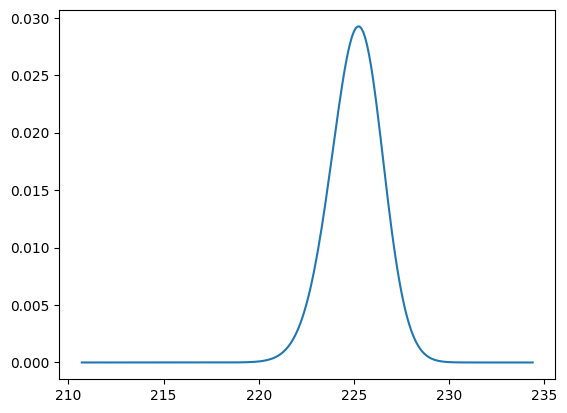

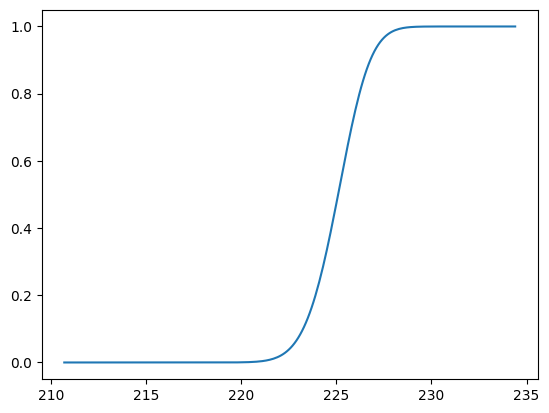

[223.2 223.3]

In [3]:
import cvxpy as cp

flag = 2
c = np.vectorize(lambda pmf: min(pmf.distribution(), key=lambda x: x[0])[0])(pmfs  # 第一小题
        ) if flag ==1 else np.vectorize(lambda pmf: pmf.expectation())(pmfs)  # 第二小题

x = cp.Variable((4, 10), integer=True)
s = cp.Variable(10, integer=True)
pro = cp.Minimize(- cp.sum(cp.multiply(c, x)))
cons = [x >= 0,
        x <= 1,
        s >= 0,
        s <= 1,
        cp.sum(s) == 4,
        cp.sum(x) == 24,
        cp.sum(x, axis=1) == 6,
        cp.sum(x, axis=0) >= 4 * s]
prob = cp.Problem(pro, cons)
prob.solve(solver='GLPK_MI')  # pip install mkl
print(- prob.value)
print(x.value)

if flag == 2:
    pmf_tree = pmfs[np.vectorize(bool)(x.value)]  # bool 索引
    p_tree = create_pmftree(list(pmf_tree))
    # graph_pmftree(p_tree)
    plot_pmf(p_tree.data)
    x, y = plot_cdf(p_tree.data)
    # print(len(x),len(y))
    print(x[abs(y - 0.1) <= 0.01])
